# Sampling Approach
-------------

[<img src="http://brazildatacube.org/wp-content/uploads/slider2/datacube-site.png" alt="BDC" width="200" align="right">](http://brazildatacube.org/about-brazil-data-cube/)

## Author:
 - Leonardo de Souza Vieira

## Adivisors
 - Dr. Gilberto Ribeiro de Queiroz
 - Dr. Elcio Hideiti Shiguemori
------------

# 1. Introduction

---------

The python codes using a list of packages, where each package is used in a specific development step. Bellow we show short description of the used packages

<ul>
    <li><a href='https://gdal.org/'>GDAL</a>: Manipulation of geospatial data, vetor and raster;</li>
    <li><a href='https://pandas.pydata.org/'>Pandas</a>: Data Science;</li>
    <li><a href='https://geopandas.org/'>GeoPandas</a>: Analysis of vector type geospatial data;</li>
    <li><a href='https://rasterio.readthedocs.io/en/latest/'>Rasterio</a>: Manipulation of geospatial data raster type;</li>
    <li><a href='https://pyproj4.github.io/pyproj/stable/'>PyPROJ</a>: Python interface to cartographic projections;</li>
    <li><a href='https://pypi.org/project/psycopg2/'>Psycopg </a>: PostgreSQL Data base conection;</li>
    <li><a href='https://numpy.org/'>Numpy</a> Numerical computations, matrix n-dimensional;</li>
    <li><a href='https://matplotlib.org/'>Matplotlib</a>: Creating static, animated, and interactive visualizations in Python. </li>
</ul>

Besides this packages also is imported some python functions that can be see it in "sampling_geodb.py". The next cell show how we can import the packages and python functions.

In [1]:
from datetime import datetime
import geopandas as gpd
import json
import matplotlib
import numpy as np
import pandas as pd
import pyproj
import psycopg2
import rasterio
import stac
from typing import List, Dict
from matplotlib import pyplot as plt
from osgeo import gdal
from rasterio import features
from shapely import wkt
from matplotlib import pyplot
from sampling_geodb import  get_bbox,conn_db,get_items, sampling
import warnings
warnings.filterwarnings('ignore')

-------------

## <span style="color:#336699; font-size: 80%; text-decoration:underline;"> BDC data base conection  </span>

The study development uses PRODES geodata in the sampling. The geodata was stored in a Postgis server available by Brazil Data Cube project. All Prodes data can be downloaded at Terrabrasilis portal (href='http://terrabrasilis.dpi.inpe.br/downloads/). The cell bellow uses the function conn_db() to connect at the PRODES database used in all study.  

In [2]:
pg_conn = conn_db('../data/json/my_pass.json')

-------------

## <span style="color:#336699; font-size: 80%; text-decoration:underline;"> Region of Interest (ROI) </span>

The ROI are the state of Rondônia, Brazil. The region was suffering with intense deforestation at the last years. Rondônia is one of the Brazilian states that deforest the most, and have proportionally the largest rate considering the area of state and the deforestation area. Also, the State no  are so large like Amazonas or Para (other states with great rate of deforestation), we consider that would make it difficult make it difficult this initial analysis. Bellow we present the ROI using The Legal Amazon Forest over Brazil at referee.

In [3]:
# Define the projection used in the BDC grids
crs_bdc = pyproj.CRS("+proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs")

# Obtain data of Brazil Biomes
query_legal_amazon = "SELECT gid, id, nome, geom FROM ibge.biomas WHERE nome = 'Amazônia';"
brazil_bla_gdf = gpd.read_postgis( sql=query_legal_amazon, con=pg_conn, crs=crs_bdc)

# Obtain data of Brazil States
query_brazil_states = "SELECT gid, __gid, cd_uf, nm_uf,sigla_uf,nm_regiao, geom FROM ibge.uf_2020;"
brazil_states_gdf = gpd.read_postgis( sql=query_brazil_states, con=pg_conn, crs=crs_bdc)

sql_roi = "WITH geom_buffer AS (SELECT ST_BUFFER(geom, 90000) AS geom FROM bdc.bdc_sm WHERE tile = '078094') \
           SELECT ST_TRANSFORM(ST_UNION(bdc.geom), 4674)  AS geom \
                FROM bdc.bdc_sm AS bdc, geom_buffer \
           WHERE ST_INTERSECTS(bdc.geom, geom_buffer.geom);"

roi_gdf = gpd.read_postgis( sql=sql_roi, con=pg_conn, crs=4674)

sql_grid = "WITH geom_buffer AS (SELECT ST_BUFFER(geom, 90000) AS geom FROM bdc.bdc_sm WHERE tile = '078094') \
           SELECT bdc.gid AS gid, bdc.id AS id, bdc.tile AS tile, ST_TRANSFORM(bdc.geom, 4674) AS geom \
                FROM bdc.bdc_sm AS bdc, geom_buffer \
           WHERE ST_INTERSECTS(bdc.geom, geom_buffer.geom);"


grid_gdf = gpd.read_postgis( sql=sql_grid, con=pg_conn, crs=4674)

--------

### <span style="color:#336699; font-size: 80%; text-decoration:underline;"> Plot Map </span>

The next cell show how we can to plot the geodata. The code uses the dataframes obtained above.

<AxesSubplot:title={'center':'ROI in Brazilian Legal Amazon (BLA)'}>

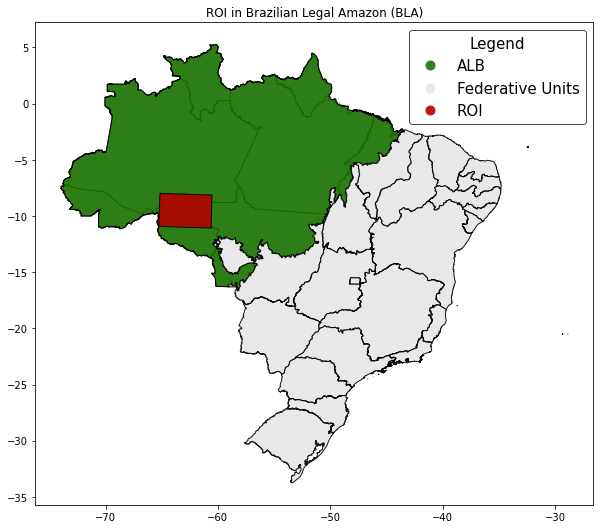

In [4]:
# Create Labels to Map plot
brazil_bla_gdf["label_plot"] = "ALB"
brazil_states_gdf["label_plot"] = "Federative Units"
rondonia_gdf = brazil_states_gdf.loc[brazil_states_gdf['sigla_uf'] == 'RO']
roi_gdf["label_plot"] = "ROI"

# Create collor map to plot
colors = [ (0.1, 0.45, 0.0),(0.9,0.9,0.9), (0.7, 0.0, 0.0)]
cmap_name = 'legendROI'
mycmap = matplotlib.colors.ListedColormap(colors, name=cmap_name, N=3)

# Create the plot geometries list.

to_plot_legend_gdf = pd.concat([brazil_states_gdf, brazil_bla_gdf, roi_gdf])

# Map plot
fig, ax = plt.subplots(figsize=(10,10))

ax.set_title(u'ROI in Brazilian Legal Amazon (BLA)')
to_plot_legend_gdf.plot(ax=ax, 
                        edgecolor='black',
                        column='label_plot',
                        cmap = mycmap,
                        legend=True,
                        alpha=0.9,
                        legend_kwds={'edgecolor': '0.1', 'title_fontsize': 15, 'fontsize': 15, 'title': "Legend"} )

--------------
### PRODES (2017-2019)

In [3]:
crs_bdc = pyproj.CRS("+proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs")
sql_roi = "WITH geom_buffer AS (SELECT ST_BUFFER(geom, 90000) AS geom FROM bdc.bdc_sm WHERE tile = '078094') \
           SELECT bdc.gid AS gid, bdc.id AS id, bdc.tile AS tile, bdc.geom  AS geom \
                FROM bdc.bdc_sm AS bdc, geom_buffer \
           WHERE ST_INTERSECTS(bdc.geom, geom_buffer.geom);"

roi_gdf = gpd.read_postgis( sql=sql_roi, con=pg_conn, crs=crs_bdc)

In [5]:
prodes_roi = {}
for t in roi_gdf['tile']:
    sql = "SELECT * FROM prodes_by_tile(\'{}\', \'{}\', {})".format(t, 'floresta_anual', 2019)
    floresta_2019 = gpd.read_postgis(sql=sql, crs=crs_bdc, con=pg_conn)
    sql = "SELECT * FROM prodes_by_tile(\'{}\', \'{}\', {})".format(t, 'incremento_anual', 2017)
    desmatamento_2017 = gpd.read_postgis(sql=sql, crs=crs_bdc, con=pg_conn)
    prodes_roi[t] = [desmatamento_2017, floresta_2019]

In [42]:
for t in roi_gdf['tile']:
    prodes_roi[t][0]['class_id']= 175
    prodes_roi[t][1]['class_id']= 176

------------
### Start and End Date for time series

In [35]:
start_date = []
# end_date = []
for t in roi_gdf['tile']:
    start_date.append(prodes_roi[t][0]['image_date'].max())
    # end_date.append(prodes_roi[t][1]['image_date'].min())
start_date = max(start_date)
end_date = datetime.date(2019, 7, 31)
# end_date = min(end_date)

------
### Raster

In [44]:
import rasterio
def rasterize_gdf(geom_gdf: gpd.GeoDataFrame, column_classes: str, path_raster_ref: str,
                  path_raster_output: str) -> np.array:
    """Create a raster data from GeoDataFrame based in column classes
            Args:
                geom_gdf (gpd.GeoDataFrame): GeoDataFrame with labeled polygon

                column_classes (str): GeoDataFrame column with value to create a raster

                path_raster_ref (str): Image path used as a reference

                path_raster_output (str): Image path used to save a raster based in geom_gdf
            Returns:
                burned (np.array): numpy array with data saved in raster
            """
    raster_ref = rasterio.open(path_raster_ref)
    meta = raster_ref.meta.copy()
    meta.update(compress='lzw')

    with rasterio.open(path_raster_output, 'w+', **meta) as out:
        out_arr = out.read(1)

        shapes = ((geom, value) for geom, value in zip(geom_gdf.geometry, geom_gdf[column_classes]))

        burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
        
        out.write_band(1, burned)

In [46]:
# pd.concat([desmatamento_pv_2017, floresta_pv_2018], ignore_index=True)
for t in roi_gdf['tile']:
    print(t)
    composed = pd.concat([prodes_roi[t][0],prodes_roi[t][1]], ignore_index=True)
    rasterize_gdf(composed,
                  'class_id',
                  '../data/imagens/S2-SEN2COR_10_16D_STK_v001_'+ t +'_2018-05-25_2018-06-09_NDVI.tif',
                  '../data/imagens/composed/S2_30_PRODES_2017_2019_'+ t +'.tif')

077094
077095
077093
078093
079093
078094
078095
079094
079095


In [8]:
with open('../data/json/my_pass.json') as json_file:
    my_pass = json.load(json_file)

In [ ]:
bdc_stac_service = stac.STAC("https://brazildatacube.dpi.inpe.br/stac/",access_token=my_pass["STAC_TOKEN"])
collection = bdc_stac_service.collection('S2-SEN2COR_10_16D_STK-1')

In [17]:
crs_bdc = pyproj.CRS("+proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs")
sql = "SELECT * FROM prodes_by_tile(\'{}\', \'{}\', {})".format('077095', 'floresta_anual', 2019)
floresta_2019 = gpd.read_postgis(sql=sql, crs=crs_bdc, con=pg_conn)

In [18]:
crs_bdc = pyproj.CRS("+proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs")
sql = "SELECT * FROM prodes_by_tile(\'{}\', \'{}\', {})".format('077095', 'incremento_anual', 2018)
desmatamento_2018 = gpd.read_postgis(sql=sql, crs=crs_bdc, con=pg_conn)

In [ ]:
start_date = desmatamento_2017['image_date'].max()
end_date = floresta_2018['image_date'].min()
print(start_date, end_date)

In [20]:
prodes = pd.concat([desmatamento_2018, floresta_2019], ignore_index=True)
prodes.head(2)

,gid,id,origin_id,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,scene_id,source,satellite,sensor,geom
0,8444,801166,10166,RO,23367,DESMATAMENTO,d2018,0.0,196,2018-07-15,2018,5.333007e-08,101020.0,None,None,None,"POLYGON ((3803762.695 10184734.217, 3803762.10..."
1,8454,801595,10592,RO,23367,DESMATAMENTO,d2018,0.0,196,2018-07-15,2018,5.606030e-05,101020.0,None,None,None,"POLYGON ((3808517.074 10204050.611, 3808516.94..."


<AxesSubplot:title={'center':'PRODES Composed 2017/2018'}>

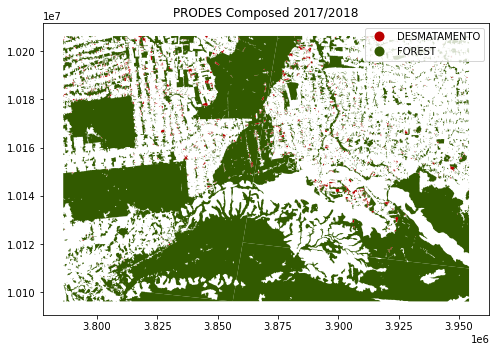

In [21]:
colors = [(0.73, 0.0, 0.0), (0.19607843137254902, 0.35294117647058826, 0.0),(0.7, 0.7, 0.7) ]
cmap_name = 'prodes_legend'

mycmap = matplotlib.colors.ListedColormap(colors, name=cmap_name, N=2)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('PRODES Composed 2017/2018')
prodes.plot(ax=ax, column = 'main_class',  cmap = mycmap,legend=True)


In [ ]:
def rasterize_gdf(geom_gdf: gpd.GeoDataFrame, column_classes: str, path_raster_ref: str,
                  path_raster_output: str) -> np.array:
    """Create a raster data from GeoDataFrame based in column classes
            Args:
                geom_gdf (gpd.GeoDataFrame): GeoDataFrame with labeled polygon

                column_classes (str): GeoDataFrame column with value to create a raster

                path_raster_ref (str): Image path used as a reference

                path_raster_output (str): Image path used to save a raster based in geom_gdf
            Returns:
                burned (np.array): numpy array with data saved in raster
            """
    raster_ref = rasterio.open(path_raster_ref)
    meta = raster_ref.meta.copy()
    meta.update(compress='lzw')

    with rasterio.open(path_raster_output, 'w+', **meta) as out:
        out_arr = out.read(1)

        shapes = ((geom, value) for geom, value in zip(geom_gdf.geometry, geom_gdf[column_classes]))

        burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
        
        out.write_band(1, burned)

In [25]:
items_porto_velho = get_items(collection, filter={'bbox':'-65.0, -10.32, -63.8, -10.37',
                       'datetime':'2017-08-01/2017-09-30', 'limit' : '1'})


In [33]:
items_porto_velho["features"][0]['assets']['NDVI']['href']

'http://bdc-ws.dpi.inpe.br/cubes/composed/S2-SEN2COR_10_16D_STK/v001/077095/2017-09-30_2017-10-15/S2-SEN2COR_10_16D_STK_v001_077095_2017-09-30_2017-10-15_NDVI.tif?access_token=XA2vulSNypRC9Yk6xJ1xkHCDaKZwNzQJSoU9FN2R7T?access_token=XA2vulSNypRC9Yk6xJ1xkHCDaKZwNzQJSoU9FN2R7T'

In [ ]:
'078094'

In [2]:
df = sampling('../data/imagens/composed/S2_30_PRODES_2017_2019_077094.tif',
         175,
         '2017-08-01',
         '2017-09-30',
         "random",
         True,
         2)

[3941221.727747917]
[10223489.850039005]
[-9.844373294514869]
[-63.79423777129403]


In [4]:
samples_tiles = []
n_samples = 0
for tile in roi_gdf['tile']:
    for label in [175, 176]:
        if label == 175:
            n_samples = 6500
        else:
            n_samples = 5000
        samples_tiles.append(sampling('../data/imagens/composed/S2_30_PRODES_2017_2019_'+ tile + '.tif',
                                label,
                                '2017-08-01',
                                '2017-09-30',
                                "random",
                                True,
                                n_samples))
samples = pd.concat(samples_tiles, ignore_index=True)

In [ ]:
samples.to_csv("../data/csv/samples.csv",index=True)